## Data

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from torchvision.transforms import ToTensor

training_data = torchvision.datasets.MNIST(root='./data', transform=ToTensor(), download=True)
test_data = torchvision.datasets.MNIST(root='./data', train=False, transform=ToTensor(), download=True)

In [4]:
from torch.utils.data import DataLoader

training_dataloader = DataLoader(training_data, batch_size=len(training_data), shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

In [5]:
X_training, Y_training = next(iter(training_dataloader))
X_training.shape, Y_training.shape

(torch.Size([60000, 1, 28, 28]), torch.Size([60000]))

In [6]:
X_test, Y_test = next(iter(test_dataloader))
X_test.shape, Y_test.shape

(torch.Size([10000, 1, 28, 28]), torch.Size([10000]))

In [7]:
X_training = X_training.reshape(60000, 784)
Y_training = Y_training
X_test = X_test.reshape(10000, 784)
Y_test = Y_test
X_training.shape, Y_training.shape, X_test.shape, Y_test.shape

(torch.Size([60000, 784]),
 torch.Size([60000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_training, Y_training, test_size=0.2)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

(torch.Size([48000, 784]),
 torch.Size([12000, 784]),
 torch.Size([48000]),
 torch.Size([12000]))

## NN

In [9]:
device = 'cpu'

In [10]:
from scripts.utils import make_dataloader

train_dataloader, val_dataloader = make_dataloader(X_train, Y_train, batch_size=32, shuffle=True), make_dataloader(X_val, Y_val, batch_size=32)

In [11]:
from torch import nn

class SimpleNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=784, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=10),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        return self.layers(x)


In [12]:
model_nn = SimpleNN()

In [13]:
from scripts.metrics import CategoricalAccuracy

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_nn.parameters())
metric = CategoricalAccuracy()

In [14]:
from scripts.train import train_model

history = train_model(
    model=model_nn,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    metric=metric,
    epochs=50,
    device=device
)

Training model for 50 epochs. Early stopping not enabled.
Epoch: 1 => Train loss: 1.680648, Train score: 0.797708, Val loss: 1.566516, Val score: 0.899333
Epoch: 2 => Train loss: 1.551773, Train score: 0.912792, Val loss: 1.551427, Val score: 0.912833
Epoch: 3 => Train loss: 1.536668, Train score: 0.926813, Val loss: 1.539879, Val score: 0.922833
Epoch: 4 => Train loss: 1.526692, Train score: 0.936292, Val loss: 1.528542, Val score: 0.934167
Epoch: 5 => Train loss: 1.520205, Train score: 0.942667, Val loss: 1.523900, Val score: 0.938250
Epoch: 6 => Train loss: 1.517088, Train score: 0.945354, Val loss: 1.521673, Val score: 0.939833
Epoch: 7 => Train loss: 1.512786, Train score: 0.949354, Val loss: 1.522223, Val score: 0.939250
Epoch: 8 => Train loss: 1.509743, Train score: 0.951937, Val loss: 1.517654, Val score: 0.944083
Epoch: 9 => Train loss: 1.507016, Train score: 0.954875, Val loss: 1.517156, Val score: 0.943417
Epoch: 10 => Train loss: 1.505317, Train score: 0.956167, Val loss: 1

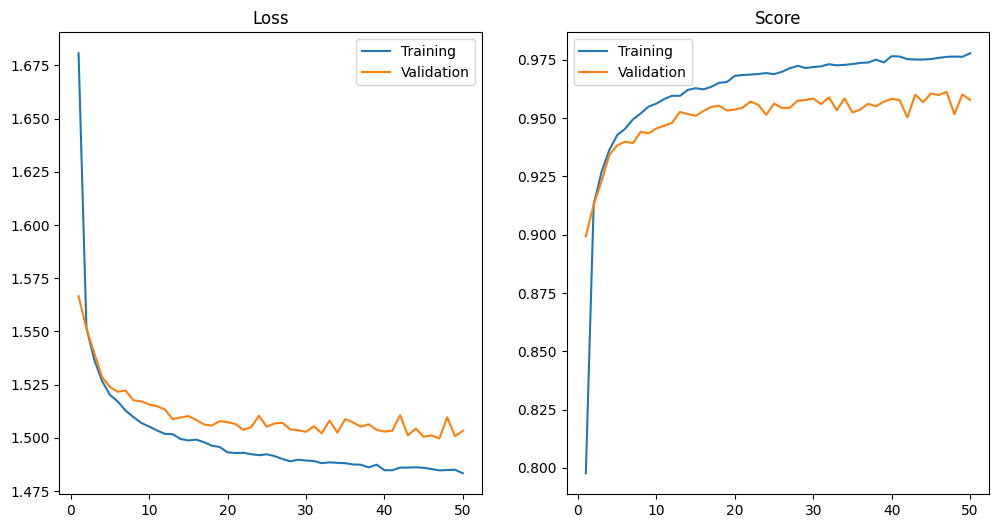

In [15]:
from scripts.utils import plot_train_history

plot_train_history(history)

In [16]:
from scripts.test import predict

preds_train, preds_val = predict(model_nn, X_train, device), predict(model_nn, X_val, device)
score_train, score_val = metric(preds_train, Y_train), metric(preds_val, Y_val)
score_train, score_val

(tensor(0.9770), tensor(0.9578))

In [17]:
preds_test = predict(model_nn, X_test, device)
score_test = metric(preds_test, Y_test)
score_test

tensor(0.9609)

In [18]:
preds_nn = torch.argmax(preds_test, dim=1)
preds_nn

tensor([7, 2, 1,  ..., 4, 5, 6])

## NTK

In [19]:
def get_grads_single_output(u, channel, model):
    return torch.cat([torch.reshape(grads, (-1,)) for grads in list(torch.autograd.grad(model(u)[0, channel], model.parameters()))]).reshape(1, -1)

def get_grads(u, model):
    # return torch.cat([get_grads_single_output(channel, model) for channel in u.reshape(-1, )])
    num_channels = len(model(u).reshape(-1))
    return torch.cat([get_grads_single_output(u, channel, model) for channel in range(num_channels)])

def compute_ntk(U, V, model):
    phi_u = torch.cat([get_grads(u.unsqueeze(0), model) for u in U])
    phi_v = torch.cat([get_grads(v.unsqueeze(0), model) for v in V])
    return torch.matmul(phi_u, phi_v.T)

In [20]:
class NTK():
    def __init__(self, model) -> None:
        self.model = model
    
    def get_ntk(self, U, V):
        return compute_ntk(U, V, self.model)

In [21]:
u = torch.randn(1, 784)
get_grads(u, model_nn)

tensor([[ 0.0000e+00,  0.0000e+00, -0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-9.9998e-16, -4.3518e-15,  1.6141e-14,  ..., -4.0628e-15,
          0.0000e+00,  0.0000e+00],
        [-3.5411e-35, -1.5411e-34,  5.7158e-34,  ..., -9.4940e-35,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 4.1098e-16,  1.7885e-15, -6.6338e-15,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])

## SVM

In [22]:
from sklearn.metrics import accuracy_score

In [23]:
from sklearn.svm import SVC

### T = 0

In [24]:
ntk_init = NTK(SimpleNN().to(device))

In [25]:
model_km_init = SVC(kernel=ntk_init.get_ntk)

In [ ]:
model_km_init.fit(X_train, Y_train)

In [ ]:
preds_train, preds_val = model_km_init.predict(X_train), model_km_init.predict(X_val)
score_train, score_val = accuracy_score(Y_train, preds_train), accuracy_score(Y_val, preds_val)
score_train, score_val